In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import torch
from torch import nn, optim
from torchvision import transforms, datasets

In [3]:
from my_ml_lib import MetricTools, PlotTools

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
data_dirs = {
    'train': 'quickdraw/train/',
    'valid': 'quickdraw/valid/',
    'test': 'quickdraw/test/',
}

In [6]:
for d in ['train', 'valid', 'test']:
    os.rmdir(data_dirs[d] + '.ipynb_checkpoints') 

FileNotFoundError: [Errno 2] No such file or directory: 'quickdraw/train/.ipynb_checkpoints'

In [7]:
files = os.listdir(data_dirs['train'])
idx_to_class = sorted([f.split('_')[-1].split('.')[0] for f in files])

class_to_idx = {idx_to_class[i]: i for i in range(len(idx_to_class))}

len(idx_to_class), class_to_idx, idx_to_class

(20,
 {'airplane': 0,
  'alarm clock': 1,
  'banana': 2,
  'baseball bat': 3,
  'bicycle': 4,
  'candle': 5,
  'car': 6,
  'crown': 7,
  'dumbbell': 8,
  'eye': 9,
  'fish': 10,
  'flower': 11,
  'hat': 12,
  'headphones': 13,
  'ice cream': 14,
  'knife': 15,
  'pants': 16,
  'shoe': 17,
  'umbrella': 18,
  'windmill': 19},
 ['airplane',
  'alarm clock',
  'banana',
  'baseball bat',
  'bicycle',
  'candle',
  'car',
  'crown',
  'dumbbell',
  'eye',
  'fish',
  'flower',
  'hat',
  'headphones',
  'ice cream',
  'knife',
  'pants',
  'shoe',
  'umbrella',
  'windmill'])

In [8]:
data_transforms = {
    'train':transforms.Compose([
            transforms.RandomRotation(10),
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'valid':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
#             transforms.Normalize([0.155], [0.316])
        ])
}

In [9]:
dataset = {}
# mean, std = None, None

for d in ['train', 'valid', 'test']:
    data_x = []
    data_y = []
    for path, _, files in os.walk(data_dirs[d]):
        for f in files:
            c = f.split('_')[-1].split('.')[0] # get class name from file name
            x = np.load(path + f).reshape(-1, 28, 28) / 255
            y = np.ones((len(x), 1), dtype=np.int64) * class_to_idx[c]
            
            data_x.extend(x)
            data_y.extend(y)
#     if d == 'train':
#         mean = np.mean(data_x)
#         std = np.std(data_x)
    dataset[d] = torch.utils.data.TensorDataset(torch.stack([data_transforms[d](Image.fromarray(np.uint8(i*255))) for i in data_x]), 
                                                torch.stack([torch.Tensor(j) for j in data_y]))


In [10]:
[len(dataset[d]) for d in ['train', 'valid', 'test']]

[392000, 168000, 140000]

In [11]:
bs = 128 # batch size

In [12]:
dataloaders = {
    d: torch.utils.data.DataLoader(dataset[d], batch_size=bs, shuffle=True) for d in ['train', 
                                                                                      'valid', 
                                                                                      'test']
}

In [13]:
invTrans = transforms.Compose([ transforms.Normalize([0.],[1/0.316]),
                                transforms.Normalize([-0.155],[1.]),
                               ])

def imshow(img):
#     img = invTrans(img)
#     img = img.numpy()
    plt.imshow(img.reshape(28,28), cmap='gray')

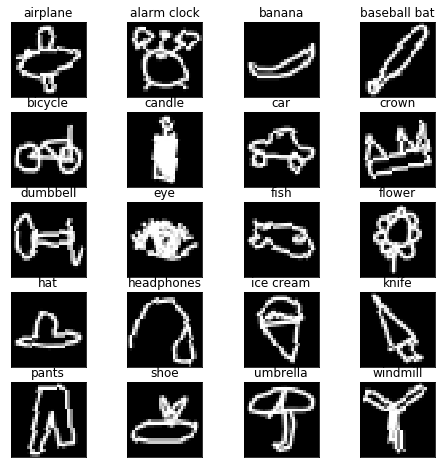

In [14]:
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

fig = plt.figure(figsize=(8, 8))
# display 9 images
for cls in np.arange(20):
    ax = fig.add_subplot(5, 4, cls+1, xticks=[], yticks=[])
    
    image = images.numpy()[labels.numpy().reshape(-1) == cls][0]
    label = labels.numpy()[labels.numpy().reshape(-1) == cls][0, 0].astype(np.int64)
    imshow(image)
    ax.set_title(idx_to_class[label])
plt.savefig('plots/data_vis.png')

In [14]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(5, 5, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 14x14x5
            nn.Conv2d(5, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 7x7x8
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU() # 7x7x16
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*16, 100),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(100, 20)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.shape[0], -1)
        out = self.fc(out)
        return out


model_scratch = Net()
model_scratch.to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(5, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=100, out_features=20, bias=True)
  )
)

In [15]:
criterion_scratch = nn.CrossEntropyLoss()

# optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    val_losses = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU or CPU
#             print(torch.max(target,1)[0])
            data, target = data.to(device), target.long().to(device)
            
            ## find the loss and update the model parameters accordingly
            ## record the average training loss as follows
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            loss.backward()
            optimizer.step()
            
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU or CPU
            data, target = data.to(device), target.long().to(device)
            
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, torch.max(target,1)[0])
            
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        
        if valid_loss < valid_loss_min:
            print('Saving model..')
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
    
    # return trained model
    return model, train_losses, val_losses

In [17]:
# train the model
model_scratch, train_losses, val_losses = train(40, dataloaders, model_scratch, optimizer_scratch, 
                                                criterion_scratch, device, 'models/model_scratch-40epochs_final.pt')

Epoch: 1 	Training Loss: 0.873504 	Validation Loss: 0.480363
Saving model..
Epoch: 2 	Training Loss: 0.554347 	Validation Loss: 0.405095
Saving model..
Epoch: 3 	Training Loss: 0.492729 	Validation Loss: 0.366853
Saving model..
Epoch: 4 	Training Loss: 0.457432 	Validation Loss: 0.349495
Saving model..
Epoch: 5 	Training Loss: 0.433494 	Validation Loss: 0.335509
Saving model..
Epoch: 6 	Training Loss: 0.418198 	Validation Loss: 0.333152
Saving model..
Epoch: 7 	Training Loss: 0.406462 	Validation Loss: 0.319218
Saving model..
Epoch: 8 	Training Loss: 0.399340 	Validation Loss: 0.324048
Epoch: 9 	Training Loss: 0.389939 	Validation Loss: 0.321131
Epoch: 10 	Training Loss: 0.383207 	Validation Loss: 0.313230
Saving model..
Epoch: 11 	Training Loss: 0.377984 	Validation Loss: 0.315521
Epoch: 12 	Training Loss: 0.373404 	Validation Loss: 0.301180
Saving model..
Epoch: 13 	Training Loss: 0.370101 	Validation Loss: 0.304857
Epoch: 14 	Training Loss: 0.364663 	Validation Loss: 0.304036
Epoch:

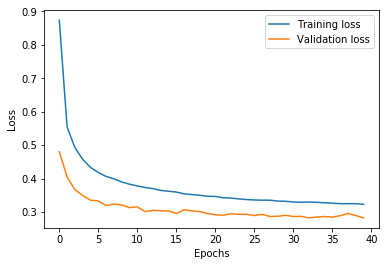

In [18]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.xticks([i for i in range(0, len(train_losses), 5)].append(len(train_losses)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
_ = plt.ylim()
# plt.title('Training Validation Loss with CNN from scratch')
plt.savefig('plots/Training Validation Loss with CNN from scratch-40epochs_final.png')
plt.show()

In [19]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('models/model_scratch-40epochs_final.pt'))

In [20]:
def mapk(target, output, k=3):
    map_sum = 0
    output = torch.topk(output, k)[1]
    for i, t in enumerate(target):
        idx = (output[i] == t).nonzero().cpu().numpy()
        if len(idx) == 0:
            continue
            
        idx = idx[0][0]
        map_sum += 1 / (idx + 1)
        
    return map_sum

In [21]:
def test(loaders, model, criterion, device):
    sigmoid = lambda x: 1 / (1 + np.exp(-x))
    
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    total_mapk = 0
    
    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU or CPU
        data, target = data.to(device), target.long().to(device)
        
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target.view(-1))
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        
        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())
        
        total_mapk += mapk(target, output)
        
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    
    map3 = np.around(total_mapk / len(loaders["test"].dataset) * 100, 2)
    print(f'\nMean Average Precision @ 3: {map3}%')
          
    return y, y_hat

In [22]:
# call test function    
y, y_hat = test(dataloaders, model_scratch, criterion_scratch, device)

Test Loss: 0.285089


Test Accuracy: 92% (129074/140000)

Mean Average Precision @ 3: 94.28%


In [23]:
MetricTools.accuracy(y, y_hat)

0.9219571428571428

In [24]:
cm = MetricTools.confusion_matrix(y, y_hat, nclasses=len(idx_to_class))

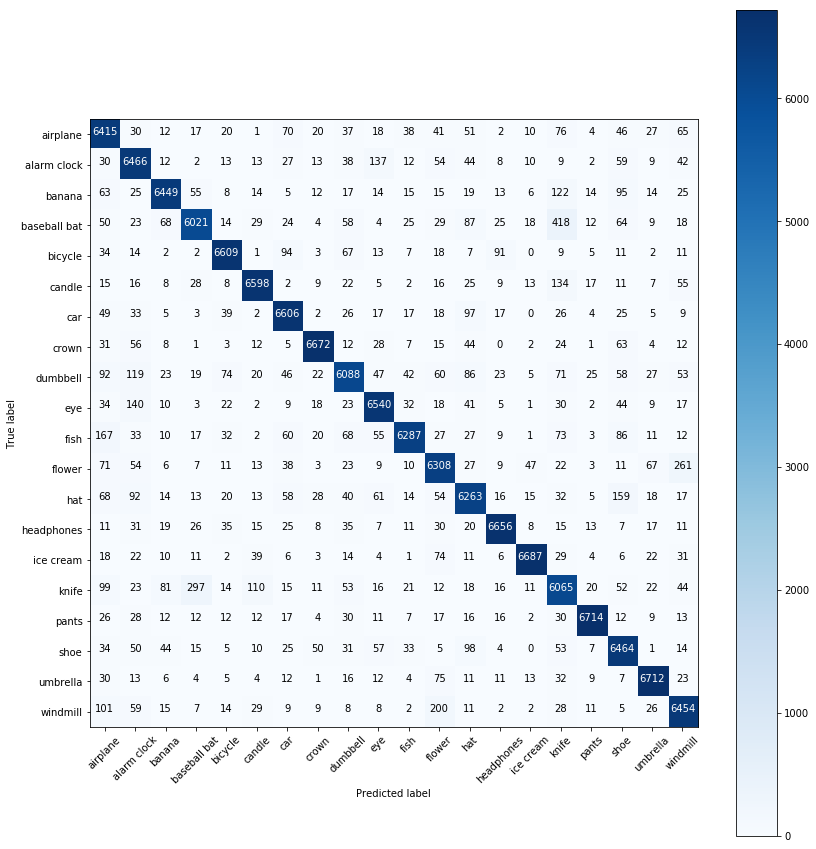

In [25]:
PlotTools.confusion_matrix(cm, idx_to_class, title='',
                           filename='Confusion Matrix with CNN from scratch-40_final', figsize=(12,12), path='plots/')

In [26]:
prec, rec = MetricTools.prec_recall(y, y_hat, len(idx_to_class))
f1 = 1 /(0.5 * (1/prec + 1/rec))

In [27]:
np.around([prec, rec, f1], 3)

array([0.923, 0.922, 0.922])